The point of this notebook is to try to group together the time buckets based on similar mean and standard deviation of the Lat/lon of the RTAs that occur in the bucket.
I use a clustering technique to see if the mean/stdev combinations can be grouped effectively

In [243]:
import pandas as pd
import numpy as np
import re
import datetime
import math
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
import geopandas as gpd
import h3 # h3 bins from uber
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch
pd.set_option('display.max_rows', None)

In [191]:
def create_crash_df(train_file = '../Inputs/Train.csv'):  
    crash_df = pd.read_csv(train_file, parse_dates=['datetime'])
    return crash_df

def standardize(crash_df):
    scaler = StandardScaler()
    crash_df[['latitude','longitude']] = scaler.fit_transform(crash_df[['latitude','longitude']])
    return crash_df
    
def create_temporal_features(df):
    dict_windows = {1: "00-03", 2: "03-06", 3: "06-09", 4: "09-12", 5: "12-15", 
                    6: "15-18", 7: "18-21", 8: "21-24"}
    dict_months = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                   7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}
    rainy_season = ["Mar", "Apr", "May", "Oct", "Nov", "Dec"]
    df["time_window"] = df["datetime"].apply(lambda x: math.floor(x.hour / 3) + 1)
    df["time_window_str"] = df["time_window"].apply(lambda x: dict_windows.get(x))
    df["day"] = df["datetime"].apply(lambda x: x.day)
    df["month"] = df["datetime"].apply(lambda x: dict_months.get(x.month))
    df["year"] = df["datetime"].apply(lambda x: x.year)
    df["weekday"] = df["datetime"].apply(lambda x: x.weekday())
    df["rainy_season"] = df["month"].apply(lambda x: 1 if (x in rainy_season) else 0)
    return df

def assign_hex_bin(df,lat_column="latitude",lon_column="longitude"):
    df["h3_zone_5"] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], 5),axis=1)
    df["h3_zone_6"] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], 6),axis=1)
    df["h3_zone_7"] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], 7),axis=1)
    return df

In [250]:
# load data and apply feautre engineering, drop unnessecary columns
crash_df = create_crash_df(train_file = '../nairobi-capstone/Inputs/Train.csv')
crash_df = standardize(crash_df)
crash_df = create_temporal_features(crash_df)
crash_df = assign_hex_bin(crash_df)
crash_group = crash_df.groupby(['time_window_str', 'weekday'])

group_stats = crash_group.agg({'latitude': [np.mean, np.std],'longitude': [np.mean, np.std, 'count']})

# flatten out groupby object and rename columns
group_stats = group_stats.reset_index()
group_stats.columns = group_stats.columns.get_level_values(0)
group_stats.columns.values[[2,3,4,5,6]] = ['latitude_mean', 'latitude_std',
                                           'longitude_mean', 'longitude_std', 'RTA_count']

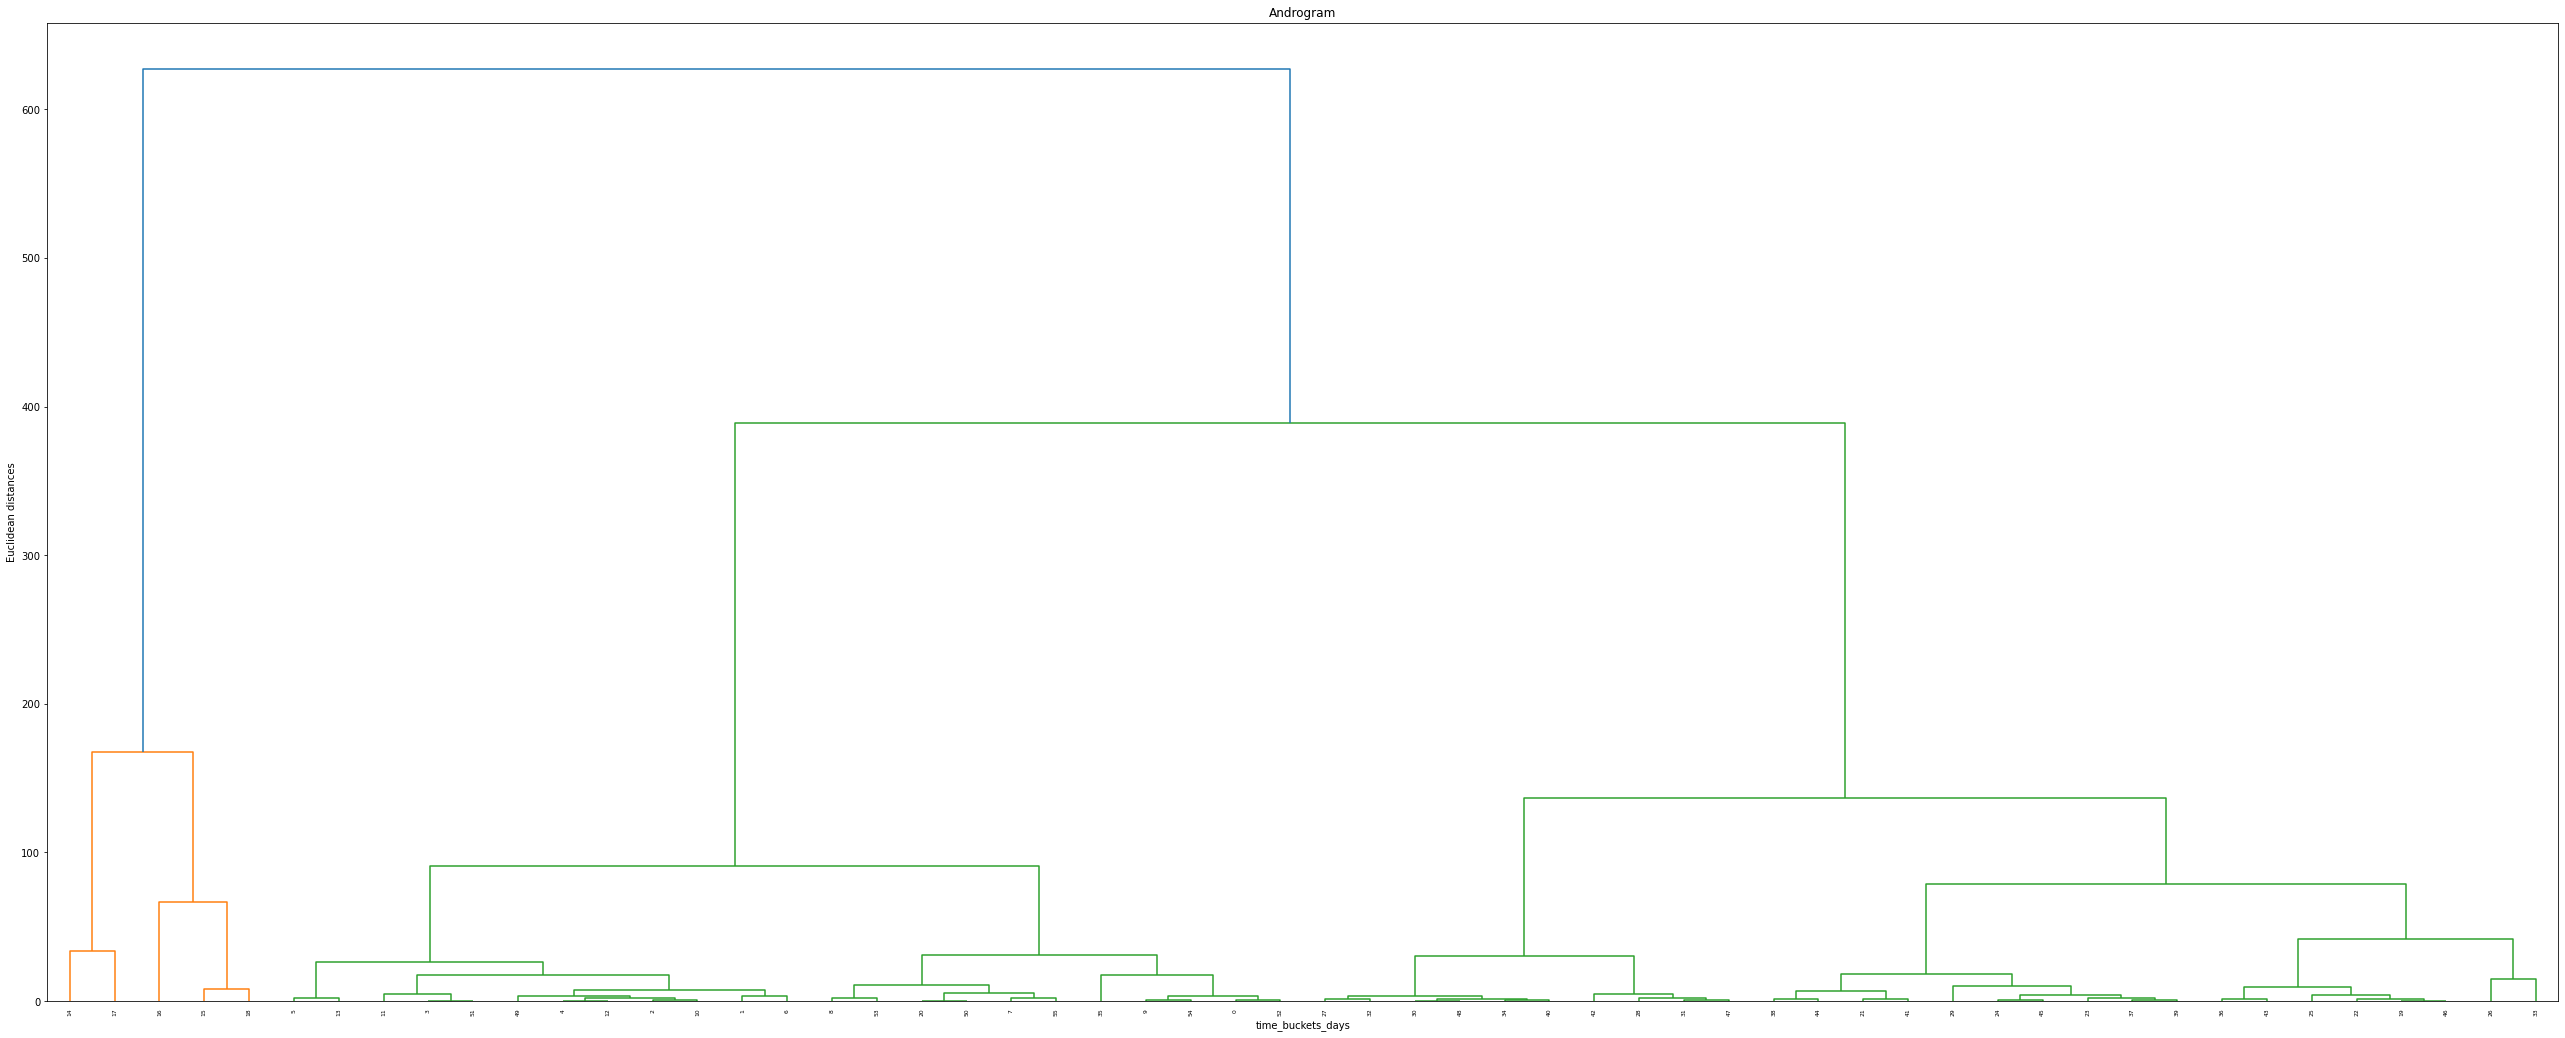

In [272]:
# Use Dendrogram to determine an optimal number of clusers
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(45,18))
plt.title('Androgram')
plt.xlabel('time_buckets_days')
plt.ylabel('Euclidean distances')
dendrogram = sch.dendrogram(sch.linkage(group_stats[
    ['latitude_mean', 'latitude_std','longitude_mean', 'longitude_std','RTA_count']], method = 'ward'))
plt.show()

### Based on the dendrogram, there should be 2 or 3 clusters of time buckets based on the mean and standard devation and RTA count. 
the first cluster is very small relative to the second. Perhaps 3 clusters could then be taken as there is quite a lot of difference between the other two big groups.

(56,)
5


RTA_count      
              sum count
cluster                
0            2839    21
1            1786    29
2             657     3
3             652     2
4             384     1

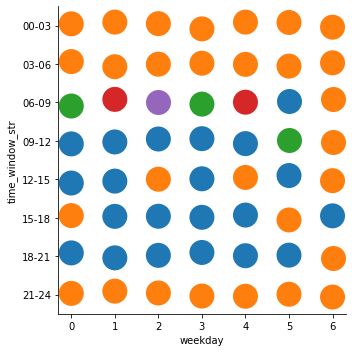

In [271]:

X = group_stats[['latitude_mean', 'latitude_std','longitude_mean', 'longitude_std','RTA_count']]

# GMM model
    #gmm = GaussianMixture(n_components=5, verbose=10, random_state=42)
    #gmm.fit(X)
    #labels = gmm.predict(X)

# mean_shift model
ms_model = MeanShift().fit(X)
cluster_centers = ms_model.cluster_centers_
labels = ms_model.labels_
print(labels.shape)
print(len(cluster_centers))

labels = pd.DataFrame(labels,columns=['cluster'])
clustered_time_buckets = pd.concat([group_stats,labels], axis=1)
#display(clustered_time_buckets)
tb_clusers = sns.FacetGrid(clustered_time_buckets,hue='cluster', height=5) # ,col="rainy_season"
tb_clusers.map(sns.stripplot,'weekday', 'time_window_str', s=25, order = ['00-03', '03-06', '06-09', '09-12', 
                                                                          '12-15', '15-18', '18-21', '21-24'])
# Number of RTAs & time buckets in each cluster
display(clustered_time_buckets.groupby('cluster').agg({'RTA_count': [np.sum, 'count']}))


In [211]:
# hard code TW_clusers:

In [263]:
crash_df_with_cluster = create_crash_df(train_file = '../nairobi-capstone/Inputs/Train.csv')
crash_df_with_cluster = create_temporal_features(crash_df)
crash_df_with_cluster = crash_df_with_cluster.merge(clustered_time_buckets[['time_window_str', 'weekday','cluster']], how='left', on=['time_window_str', 'weekday']) #'rainy_season',
#crash_df_with_cluster.columns
#crash_df_with_cluster.drop(['uid','time_window', 'time_window_str', 'day', 'month', 'year', 'weekday', 'rainy_season', 'h3_zone_5', 'h3_zone_6', 'h3_zone_7'], axis=1, inplace=True)


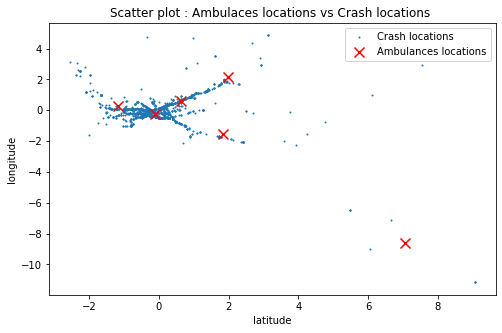

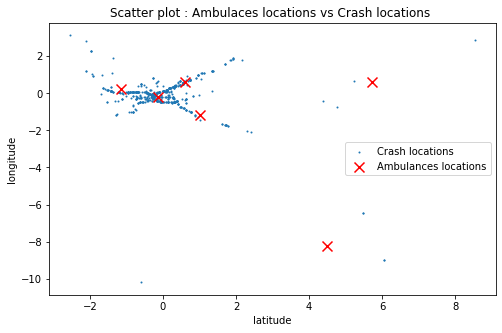

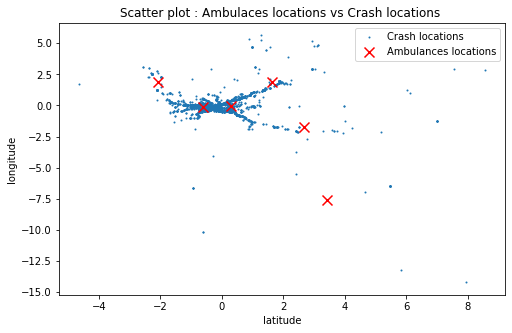

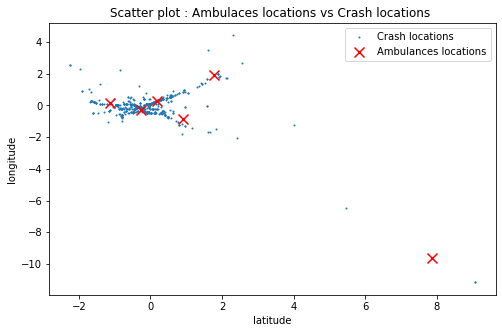

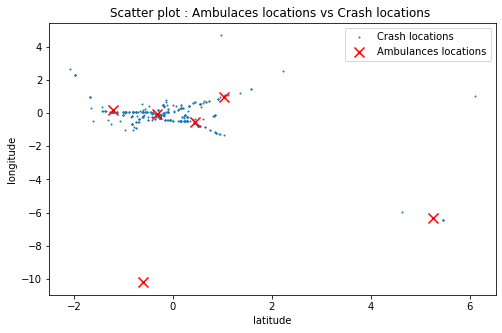

In [265]:
for i in crash_df_with_cluster.cluster.unique():
    kmeans = KMeans(n_clusters=6, verbose=0, tol=1e-3, max_iter=100, n_init=20, copy_x= True)
    kmeans.fit(crash_df_with_cluster.query('cluster==@i')[['latitude','longitude']])
    centroids = kmeans.cluster_centers_
    plot_centroids(crash_df_with_cluster.query('cluster==@i'), centroids=centroids)

In [233]:
def plot_centroids(crash_data_df, centroids=centroids):
    fig, axs = plt.subplots(figsize=(8, 5))

    plt.scatter(x = crash_data_df['longitude'], y=crash_data_df['latitude'], s=1, label='Crash locations' )
    plt.scatter(x = centroids[:,1], y=centroids[:,0], marker="x",
                color='r',label='Ambulances locations',s=100)
    axs.set_title('Scatter plot : Ambulaces locations vs Crash locations ')
    plt.xlabel("latitude")
    plt.ylabel("longitude")
    plt.legend()
    plt.show()
